In [1]:
import re

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import jieba as jb

In [2]:
train_ds='../data/train/labeled_data.csv'

In [3]:
train_df=pd.read_csv(train_ds)
# train_df=train_df.iloc[:,1:]
train_df=train_df.set_index('id',drop=True)
train_df

,class_label,content
id,,
0,教育,人民网北京8月31日电（孙竞）日前，为进一步规范高等学校命名工作，依据相关法律法规规定，结合...
1,家居,又是一年落叶黄，一阵秋雨一阵凉；整日奔波工作忙，出门别忘添衣裳。金秋时节，正值装修旺季，集美...
2,教育,作者：祝安顺（深圳大学饶宗颐文化研究院编审、副教授） 越来越多的名校毕业生入职教师行业，吸...
3,时尚,虽然此前其有过与品牌如Madawell的合作系列，但这回她确认将推出自己名下的服装系列。在最...
4,教育,眼下，虽然疫情依然严峻，但我国大中小学都已陆续开学，疫情防控进入常态化，学生校园生活回归正常...
...,...,...
6995,教育,近期，国家卫健委发布《学校传染病症状监测预警技术指南》，其中规定，学校传染病达预警指标后，应...
6996,房产,新冠肺炎疫情影响之下，房企纷纷开设“线上售楼处”。据克而瑞监测，目前超过150家房企在做线上...
6997,教育,学生犯错后，教师能不能惩戒？如何惩戒？惩戒的边界在哪里？9月起，《广东省学校安全条例》（以下...


In [4]:
# 句长分析
train_df['text_len']=train_df['content'].apply(lambda x:len(x))
train_df['text_len'].describe()

count     7000.000000
mean      1150.304857
std       1246.948134
min         31.000000
25%        502.000000
50%        832.000000
75%       1391.000000
max      40133.000000
Name: text_len, dtype: float64

200


Text(0.5, 1.0, 'Text len hist')

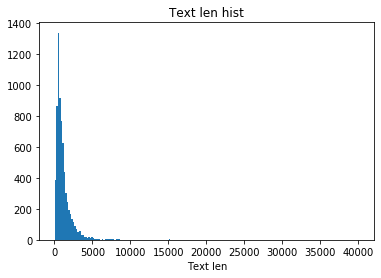

In [5]:
# 句长分布直方图
bins=int((train_df['text_len'].max()-train_df['text_len'].min())**0.5)
print(bins)
plt.hist(train_df['text_len'],bins=bins)
plt.xlabel('Text len')
plt.title('Text len hist')
# 结论： 绝大部分文本分布在5000字符以内

Text(0.5, 1.0, 'Label bar')

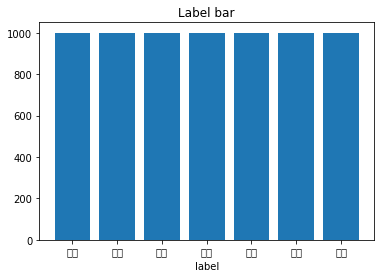

In [6]:
# 类别分布
label_cnts=dict(train_df['class_label'].value_counts())
plt.bar(label_cnts.keys(),label_cnts.values())
plt.xlabel('label')
plt.title('Label bar')
# 结论：均匀分布

In [7]:
# 预处理

## 大于4k 长度的比例
print(len(train_df[train_df['content'].str.len()>4000]['content'])/len(train_df))
## 截断到 4k
idxs=train_df.loc[train_df['content'].str.len()>4000].index
print(train_df.loc[train_df['content'].str.len()>4000].index)
train_df.loc[train_df['content'].str.len()>4000,'content']=train_df.loc[train_df['content'].str.len()>4000,'content'].apply(lambda x:x[:4000].rsplit('。',1)[0])

print(len(train_df[train_df['content'].str.len()>4000]['content'])/len(train_df))
print(list(train_df.iloc[idxs.tolist(),:]['content'].str.len()))
print(train_df.iloc[idxs[1]]['content'])

0.023142857142857142
Int64Index([  24,  121,  151,  197,  294,  415,  424,  471,  505,  542,
            ...
            6644, 6664, 6678, 6710, 6748, 6750, 6781, 6814, 6981, 6986],
           dtype='int64', name='id', length=162)
0.0
[3965, 3975, 3993, 3966, 3886, 3970, 3951, 3964, 3967, 3998, 3992, 3920, 3987, 3990, 3950, 3939, 3971, 3985, 3991, 3974, 3981, 3927, 3997, 3952, 3990, 3973, 3895, 3999, 3987, 3983, 3994, 3935, 3979, 3992, 3975, 3937, 3976, 3979, 3974, 3843, 3991, 3981, 3920, 3999, 3920, 3962, 3969, 3996, 3961, 3797, 3917, 3960, 3946, 3962, 2647, 3977, 3957, 3981, 3966, 3983, 3937, 3958, 3922, 3971, 3913, 3756, 3936, 3846, 3969, 3987, 3971, 3877, 3976, 3976, 3960, 3977, 3955, 3923, 3987, 3925, 3948, 3973, 3987, 3951, 3978, 3937, 3953, 3995, 3990, 3984, 3957, 3924, 3922, 3948, 3986, 3975, 3978, 3978, 3967, 3986, 3989, 3997, 3995, 3987, 3980, 3910, 3908, 3958, 3959, 3982, 3987, 3971, 3992, 3950, 3952, 3980, 3974, 3993, 3960, 3895, 3976, 3990, 3984, 3974, 4000, 3865, 3997, 39

In [8]:
## 标签数值化
codes,uniques=train_df['class_label'].factorize(sort=True)
train_df['label']=codes

class_label_dict={i:uniques[i] for i in range(len(uniques))}

print(codes)
print(class_label_dict)

[2 0 2 ... 2 5 4]
{0: '家居', 1: '房产', 2: '教育', 3: '时尚', 4: '时政', 5: '科技', 6: '财经'}


In [9]:
train_df.sample(10)

,class_label,content,text_len,label
id,,,,
6414,科技,就在我们以为三星今年会为我们带来S11系列的时候，三星却把新品命名为S20系列，其中S20U...,530,5
953,科技,7月8日，摩托罗拉5G新机——MotoG5GPlus正式发布，该机4GB+64GB售价349...,477,5
3014,房产,北京泰禾中央广场，是泰禾集团进驻北京的第一个楼盘，从一入市就引来很多方面的热议，京城人们也额...,714,1
6517,房产,市国土局土地拍卖现场2015年11月23日，在国土局土地交易大厅准备进行竞拍的是石景山区的一...,567,1
3623,房产,2018年底北京限竞房一出，历经大半年后，现况如何？市场业绩上是肯定的，今年排名前十的新房楼...,2579,1
28,科技,3月11日，摩托罗拉一款名为OneMid新机及其GeekBench跑分在网上曝光。同时，这款...,378,5
4768,时尚,TSL|谢瑞麟“至臻情缘”婚戒系列灵感源自当代日本的精巧设计，整体风格简洁而自然，细节处理又...,426,3
2638,科技,6月15日，StrategyAnalytics无线智能手机战略服务发布《2020年Q1智能手...,420,5
5957,时尚,这个月初，福布斯报道，31岁的流行音乐天后蕾哈娜Rihanna凭借6亿美元的总资产，成为当今...,3662,3


In [10]:
## 文本处理
### 函数：删除除字母,数字，汉字以外的所有符号
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

### 函数：获取停用词
def get_stopwords_list(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

### 加载停用词
stopwords = get_stopwords_list("../data/baidu_stopwords.txt")

In [11]:
train_df['cleaned_content']=train_df['content'].apply(remove_punctuation)
train_df.sample(10)

,class_label,content,text_len,label,cleaned_content
id,,,,,
3682,家居,开关插座十大品牌 1罗格朗 法国罗格朗是电工行业全球巨头，也是世界上最早做开关插座的品牌...,2059,0,开关插座十大品牌1罗格朗法国罗格朗是电工行业全球巨头也是世界上最早做开关插座的品牌之一业务遍...
828,时政,【八小时了，河南新乡纸厂大火还没被扑灭】央视记者在新乡新亚纸业火灾现场看到：两座仓库仍有大量...,146,4,八小时了河南新乡纸厂大火还没被扑灭央视记者在新乡新亚纸业火灾现场看到两座仓库仍有大量明火这次...
3885,时政,­ 《中国经济周刊》记者徐豪|北京报道­ 热播反腐剧《人民的名义》中，京州市光明区区长孙...,3448,4,中国经济周刊记者徐豪北京报道热播反腐剧人民的名义中京州市光明区区长孙连城每天掐表上下班一刻都...
3750,科技,有人说，淘宝发展到现在，已经越来越没流量了，靠淘宝赚钱的日子已经成为过去式。其实，这种观点是...,598,5,有人说淘宝发展到现在已经越来越没流量了靠淘宝赚钱的日子已经成为过去式其实这种观点是不对的来淘...
4785,时政,湖南湘潭县27岁副县长徐韬日前成了网络上的焦点人物。他参加工作5年，已经变换了9个工作岗位，...,1259,4,湖南湘潭县27岁副县长徐韬日前成了网络上的焦点人物他参加工作5年已经变换了9个工作岗位并在1...
5611,房产,北京首创天禧现房-北京首创天禧售楼处电话。用心打造的作品，必然会呈现出优质的效果，让住户们的...,767,1,北京首创天禧现房北京首创天禧售楼处电话用心打造的作品必然会呈现出优质的效果让住户们的生活达到...
4462,教育,92所高校60余万大学生已返校 本报记者刘冕 目前，92所在京高校已开启秋季学期学生返校...,2009,2,92所高校60余万大学生已返校本报记者刘冕目前92所在京高校已开启秋季学期学生返校工作60余...
5620,教育,【我的抗疫故事】 疫情中守好课堂阵地宁夏理工学院党委宣传部部长兼机关党支部书记 王元芳 ...,1578,2,我的抗疫故事疫情中守好课堂阵地宁夏理工学院党委宣传部部长兼机关党支部书记王元芳若不是和同事说...
520,时政,当务之急，已经不再是围绕劳教制度本身的存废之争，而应围绕“怎么改”来展开。“空谈误国、实干兴...,1095,4,当务之急已经不再是围绕劳教制度本身的存废之争而应围绕怎么改来展开空谈误国实干兴邦劳教改革同样...


In [12]:
train_df['cuted_content']=train_df['cleaned_content'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
train_df.sample(10)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/r1/54ysm_ls155b6bk8ccxch08r0000gn/T/jieba.cache
Loading model cost 0.582 seconds.
Prefix dict has been built successfully.


,class_label,content,text_len,label,cleaned_content,cuted_content
id,,,,,,
928,教育,【迈好大学第一步】 学生问：老师、学长学姐们都说大学是个资源宝库。校园里有哪些资源值得重...,865,2,迈好大学第一步学生问老师学长学姐们都说大学是个资源宝库校园里有哪些资源值得重视我该如何发掘利...,迈好 大学 第一步 学生 问 老师 学长 学姐 都 说 大学 资源 宝库 校园 里 资源 值...
6740,家居,"8月13日,由《全球智能化商业》主办,AIBA亚太人工智能商业联盟、涂鸦智能承办,宁波家电行...",1452,0,8月13日由全球智能化商业主办AIBA亚太人工智能商业联盟涂鸦智能承办宁波家电行业协会宁波市...,8 月 13 日 全球 智能化 商业 主办 AIBA 亚太 人工智能 商业 联盟 涂鸦 智能...
5388,房产,海淀万科翡翠云图怎么样？2018年，北京万科于海淀落子首个翡翠系商品住宅项目——北京万科翡翠...,615,1,海淀万科翡翠云图怎么样2018年北京万科于海淀落子首个翡翠系商品住宅项目北京万科翡翠云图旨在...,海淀 万科 翡翠 云图 2018 年 北京 万科 海淀 落子 首个 翡翠 系 商品住宅 项目...
5763,财经,周一沪深两市走势分化，周期股表现强势，科技股集体下挫。盘面上，煤炭板块大涨超4%，钢铁板块涨...,1122,6,周一沪深两市走势分化周期股表现强势科技股集体下挫盘面上煤炭板块大涨超4钢铁板块涨超3水泥有色...,周一 沪 深 两市 走势 分化 周期 股 表现 强势 科技股 集体 下挫 盘面 上 煤炭 板...
5566,教育,蒋理 时值小学入学报名之际，最近网上有传言称“2019年教育部新政策：8月31日后出生适龄...,1258,2,蒋理时值小学入学报名之际最近网上有传言称2019年教育部新政策8月31日后出生适龄儿童可以上...,蒋理 时值 小学 入学 报名 之际 网上 传言 称 2019 年 教育部 新 政策 8 月 ...
2522,财经,新股怎么申购成功？新股申购中签技巧 自从新规出台后，新股的热潮是越来越高，不需要耗费大量资...,558,6,新股怎么申购成功新股申购中签技巧自从新规出台后新股的热潮是越来越高不需要耗费大量资金只要有相...,新股 申购 成功 新股申购 中签 技巧 新规 出台 后 新股 热潮 越来越 高 不 耗费 资...
5459,时政,央视网消息(新闻联播)：欢迎仪式后，李克强同乌马拉举行会谈。 李克强首先转达习近平主席对乌...,739,4,央视网消息新闻联播欢迎仪式后李克强同乌马拉举行会谈李克强首先转达习近平主席对乌马拉总统的亲切...,央视网 消息 新闻联播 欢迎仪式 后 李克强 同乌 马拉 举行会谈 李克强 转达 习近平 主...
1545,房产,在上一次调整LPR之后，不少分析人士称接下来还有一定的调整空间，这也我们“满怀期待”。但在3...,917,1,在上一次调整LPR之后不少分析人士称接下来还有一定的调整空间这也我们满怀期待但在3月20日央...,上 调整 LPR 不少 分析 人士 称 接下来 调整 空间 满怀 期待 3 月 20 日 央...
4240,财经,未上市的公司如何估计市值？未上市公司估值方法 公司估值是指着眼于公司本身，对公司的内在价值...,3583,6,未上市的公司如何估计市值未上市公司估值方法公司估值是指着眼于公司本身对公司的内在价值进行评估...,未上市 公司 估计 市值 未上市 公司 估值 方法 公司 估值 指 着眼于 公司 本身 公司...


In [13]:
train_df.to_csv('../data/train/labeled_data_processed.csv')